In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import pickle
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load Preprocessed Data

In [2]:
data = pd.read_csv('data/fulltext_preprocessed_data.csv')
data['full_tokens'] = data['full_tokens'].apply(ast.literal_eval)
data.head()

,full_text,full_tokens,full_text_lemmatized,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,"[house, aide, even, see, letter, jason, house,...",house aide even see letter jason house aide ev...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...","[hillary, clinton, big, woman, campus, ever, g...",hillary clinton big woman campus ever get feel...,0
2,Why the Truth Might Get You Fired Why the Trut...,"[truth, might, get, fired, truth, might, get, ...",truth might get fired truth might get fired oc...,1
3,15 Civilians Killed In Single US Airstrike Hav...,"[single, single, rate, american, higher, engag...",single single rate american higher engaged act...,1
4,Iranian woman jailed for fictional unpublished...,"[iranian, woman, fictional, unpublished, story...",iranian woman fictional unpublished story woma...,1


In [3]:
X = data['full_tokens']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 

# Train Word2Vec

In [4]:
# choosing arbitrarily initially
embedding_dim = 100
window = 5

In [5]:
w2v_model = Word2Vec(
    sentences=X_train,
    vector_size=embedding_dim,
    window=window,
    min_count=1,
    sg=1,
    workers=4
)

* vector_size=100 -> 100 values will be used in the numberical vector (embeddings) used to represent each word
* window=5 -> looks at 5 words left and right (for context)
* min_count=1 -> considers words appearing once or more
* Word2Vec learns word vectors using 2 algorithms - Skip-gram (sg=1) and CBOW(Continuous Bag of Words, sg=0)
    * CBOW works to predict a target word given context words (good for small datasets)
    * Skip-gram works to predict the context words given a target word (good for large datasets and when capturing rare words is important)
* workers are the number of cpu cores used

* This word2vec model is trained on my own X_train dataset, so the embeddings obtained are specific to that dataset. The embeddings are actually randomly initialized and then trained just once using the specified algorithm (skip-gram or CBOW). Hence, these are called task-specific embeddings.

* Pretrained embeddings will be ones that are trained on very large, general-purpose corpus (like Wikipedia, Google News, etc.). These are just downloaded and not trained on our dataset.

* If this part was entirely skipped, then completely random embeddings will be initialized and then learnt directly while training the 
classifier, those values will also get updated along with all the other weights in the model. These are called embeddings learned on the fly.

# Create Input Data

In [6]:
# tokenizer = Tokenizer()
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [7]:
with open('artifacts/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

* The tokenizer builds a vocabulary only from the tokens in X_train. Then when the tokenizer is used to convert X_test
to sequences of indices any token in X_test that wasn't encountered in X_train will be ignored by default, i.e., 
it will be dropped from the sequence. This could cause the model to lose some information, so, we can instead make the 
tokenizer map the unseen tokens to a special token called OOV (out-of-vocabulary). Hence, the unseen tokens will not be 
dropped but will get mapped to a safe index.

* It is not a good practice to simply fit the tokenizer on the whole dataset (train+test) because that could lead to leakage 
of information form the test set into further model trainings.

## Generating the numerical/index sequences

In [8]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [9]:
print(X_train_seq[5],end="\n\n")
print(len(X_train_seq[5]), len(X_train.iloc[5]))

[53, 3, 91, 55, 288, 53, 3, 906, 952, 109, 91, 68, 30, 116, 32, 529, 18, 674, 254, 58, 482, 25, 3, 458, 288, 32, 68, 26, 176, 26, 5, 297, 560, 287, 371, 91, 4097, 193, 37, 325, 482, 25, 272, 2260, 3, 1398, 568, 2531, 2, 469, 1913, 85, 194, 9, 32, 33, 17, 2, 3, 206, 529, 3614, 355, 741, 8670, 104, 2206, 26, 226, 5208, 684, 49, 2, 254, 1559, 23, 2285, 194, 2416, 48, 3, 458, 61, 1860, 1748, 6658, 2, 435, 478, 1755, 1400, 2571, 285, 325, 716, 434, 1422, 3202, 325, 505, 331, 3939, 48, 663, 325, 1690, 1482, 89, 2051, 1130, 3, 32, 831, 753, 602, 44, 90, 136, 789, 3, 2, 62, 68, 280, 3042, 102, 64, 833, 179, 715, 3027, 121, 833, 35, 53, 3, 18, 1825, 2272]

139 139


In [10]:
text_lengths = [len(tokens) for tokens in data['full_tokens']]
print("Min length:", np.min(text_lengths))
print("Mean length:", np.mean(text_lengths))
print("Median length:", np.median(text_lengths))
print("90th percentile:",np.percentile(text_lengths, 90))
print("95th percentile:",np.percentile(text_lengths, 95))
print("99th percentile:",np.percentile(text_lengths, 99))
print("Max length:",max(text_lengths))

Min length: 1
Mean length: 306.23595833738926
Median length: 227.0
90th percentile: 588.0
95th percentile: 749.75
99th percentile: 1590.5499999999993
Max length: 9284


* 95% of the texts in the dataset have a length less than 750.
* But the maximum length seen is 9284 which is extremely far from the mean and 90th, 95th, and, 99th percentiles, so it is likely to be an outlier.
* The difference between the 90th and 95th percentiles is less than 200 tokens.
* The differences between 95th percentile and mean and median are between 450 and 550 tokens.
* The differences between 90th percentile and mean and median are between 280 adn 380 tokens.
* On the other hand, the differences between 99th and 95th and 90th percentiles are between 800 and 1000 tokens.
* To clearly see how and how many texts will be affected based on cutoffs, we will plot the cdfs of the lengths.

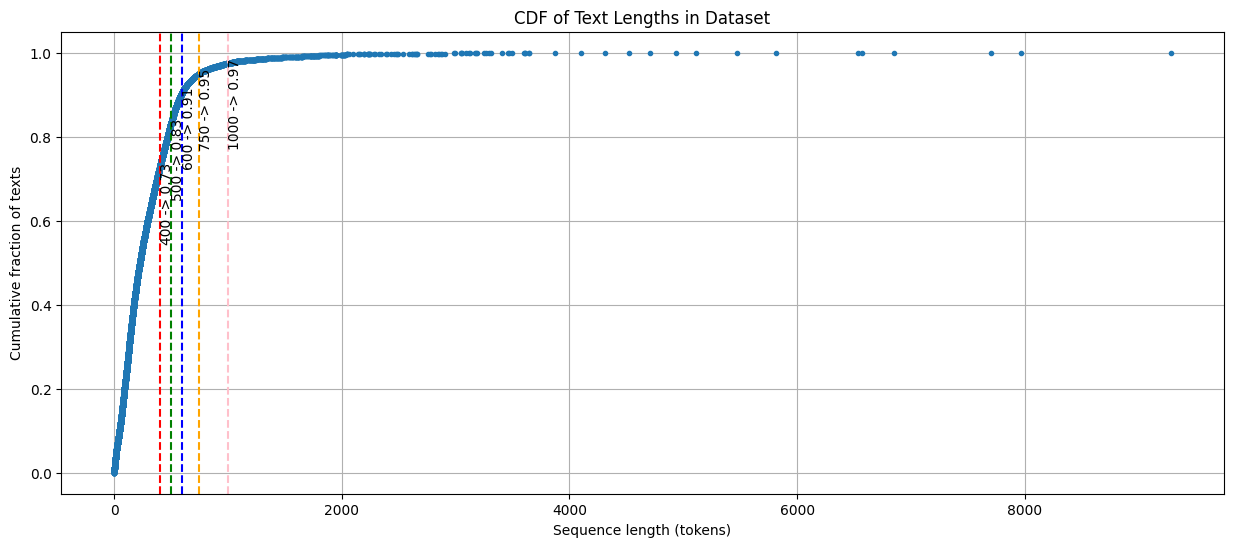

In [11]:
sorted_lengths = np.sort(text_lengths)
cdf = np.arange(1, len(sorted_lengths)+1)/len(sorted_lengths)
plt.figure(figsize=(15,6))
plt.plot(sorted_lengths, cdf, marker='.', linestyle='none')
plt.xlabel("Sequence length (tokens)")
plt.ylabel("Cumulative fraction of texts")
plt.title("CDF of Text Lengths in Dataset")
plt.grid(True)
colors = ['red', 'green', 'blue', 'orange', 'pink']
for i, cutoff in enumerate([400, 500, 600, 750, 1000]):
    fraction = np.searchsorted(sorted_lengths, cutoff, side='right')/len(sorted_lengths)
    plt.axvline(cutoff, color=colors[i], linestyle='--')
    plt.text(cutoff, fraction, f"{cutoff} -> {fraction:.2f}", rotation=90, va='center_baseline')
plt.show()

* Majority of the texts are of length less than 1000 tokens.
* Choosing the 90th percentile means 10% of the texts are truncated, while majority are padded.
* 80th to 90th percentiles are quite close. But to result in minimal loss while minimizing number of texts with padding, we will work with 90th percentile for now.

In [12]:
max_len = int(np.ceil(np.percentile(text_lengths, 90)))

## Padding the sequences

In [13]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [14]:
print(X_train_pad[5], end="\n\n")
print(len(X_train_seq[5]),len(X_train_pad[5]))

[  53    3   91   55  288   53    3  906  952  109   91   68   30  116
   32  529   18  674  254   58  482   25    3  458  288   32   68   26
  176   26    5  297  560  287  371   91 4097  193   37  325  482   25
  272 2260    3 1398  568 2531    2  469 1913   85  194    9   32   33
   17    2    3  206  529 3614  355  741 8670  104 2206   26  226 5208
  684   49    2  254 1559   23 2285  194 2416   48    3  458   61 1860
 1748 6658    2  435  478 1755 1400 2571  285  325  716  434 1422 3202
  325  505  331 3939   48  663  325 1690 1482   89 2051 1130    3   32
  831  753  602   44   90  136  789    3    2   62   68  280 3042  102
   64  833  179  715 3027  121  833   35   53    3   18 1825 2272    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [15]:
print(X_train_pad[3202], end="\n\n")
print(len(X_train_seq[3202]), len(X_train_pad[3202]))

[  121    33   154  2232   362  4292  2401  5070  1863   408    12    95
    15   261   756     7  1499    12     7  1113  1042   143   398   753
  1823  1083  3025    52   362   445     8   411   168   381   398  3454
  1965   170  2961   873    60   107   863    92    15  3220  3151     6
   516   116   810    62     2   750  1260  2961   873   613   381    30
   233    76     5   233   381   170   344   644  2512   665   841  1239
  1083  1594  3025  5070  1863  1348  2615   880  2961   873   170  8073
   240    60   107  8862  1772   709  1664    33   116  3028  1370   400
   663  2286  2147  2621   626   419 26960   846  3617   315    70     2
   666   367  2621   119    70     2   666   367  2252   846    66    70
     5   367  2282   163    92   476  1198   505  2252   251  5743     5
    42  2253  1260  2961   873     2  3151     2     4  3571   123     4
  1229    33  1889     2   311   600   126   622  1863   821  7704  9822
   141   510  3047 14303     8     2  2401    72   

In [16]:
print(list(tokenizer.word_index.items())[:10])

[('<OOV>', 1), ('said', 2), ('trump', 3), ('would', 4), ('one', 5), ('new', 6), ('time', 7), ('people', 8), ('clinton', 9), ('like', 10)]


In [17]:
vocab_size = len(tokenizer.word_index) + 1
# the tokenizer starts indexing from 1 but when padding is applied 0s are added to the sequences.
# so to accomodate 0 to the vocabulary size, 1 is added.

In [18]:
print(vocab_size)

35756


# Building Embedding Matrix

In [19]:
w2v_model.wv['said']

array([ 0.03212018,  0.21126531,  0.07104886,  0.10651404, -0.00334147,
       -0.57492197,  0.24309704,  0.3769244 , -0.21508898, -0.34461936,
        0.2257808 , -0.22543235,  0.0261388 ,  0.27930623, -0.04069815,
       -0.21267925, -0.06264514, -0.10235297, -0.10073029, -0.65680075,
        0.26233137, -0.0357024 ,  0.2445402 , -0.10640348, -0.10502984,
       -0.03551445, -0.26803082,  0.27647257, -0.37293643,  0.03609973,
        0.2101603 , -0.10730185, -0.0087979 , -0.19471566,  0.01283712,
        0.08800182,  0.0374861 ,  0.10885932,  0.1373011 , -0.3338313 ,
       -0.04587324, -0.28493243, -0.13089795, -0.05930045,  0.00274863,
       -0.03001351, -0.38437158,  0.15141906, -0.04185099,  0.2132608 ,
       -0.15448917,  0.04548088,  0.2814993 ,  0.14293256,  0.13294223,
        0.04246589,  0.26980823, -0.0916855 , -0.40968934,  0.07281284,
        0.11452814,  0.17781012,  0.15257706,  0.10171232, -0.21825172,
        0.27074704,  0.12500042,  0.0773636 , -0.15842628, -0.03

In [20]:
w2v_model.wv.index_to_key[:10]

['said',
 'trump',
 'would',
 'one',
 'new',
 'time',
 'people',
 'clinton',
 'like',
 'president']

In [21]:
print(len([t for t in w2v_model.wv.index_to_key if t not in tokenizer.word_index]))

0


In [22]:
print(len([t for t in tokenizer.word_index if t not in w2v_model.wv.index_to_key]))

1


In [23]:
c = 0
known_indices = []
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in w2v_model.wv.index_to_key:
        c += 1
        known_indices.append(index)
        embedding_matrix[index] = w2v_model.wv[word]

In [24]:
print(embedding_matrix[::10000])
print(c)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.     

* Since both tokenizer and word2vec were trained on X_train and min_count=1 (word2vec), the only missing word in the word2vec dictionary is the oov token. The embeddings for oov token can be left as 0s, be give random values, or be computed by averaging the embeddings of all other known tokens. 

* If min_count was higher, leading to word2vec skipping words that occur fewer times, or if a different corpus was used for training word2vec, and there are several words from the tokenizer vocabulary (more than 5-10%) with no embeddings, then we can initialize the embeddings for them randomly and set 'trainable=True' in the Embedding layer of classifiers, so that they'll be learnt during the model training.

In [25]:
# taking mean of the embeddings of all known tokens for the oov token
oov_token = getattr(tokenizer, 'oov_token', None)
if oov_token and oov_token in tokenizer.word_index:
    oov_index = tokenizer.word_index[oov_token]
    embedding_matrix[oov_index] = np.mean([embedding_matrix[i] for i in known_indices], axis=0)
    print(embedding_matrix[oov_index])

[ 6.67408105e-03  1.49148651e-01  6.84355590e-02  1.00343444e-01
 -3.63236967e-02 -2.15296956e-01 -7.16844942e-02  2.68578383e-01
 -3.30390855e-02 -8.44060795e-02 -1.29221092e-01 -2.30105511e-01
  1.35611215e-03  1.25924878e-01  6.30068609e-02 -1.64831314e-01
 -8.98780898e-03 -1.67719715e-01  9.88259201e-02 -3.52187339e-01
  5.23495376e-02 -3.66099274e-02  8.34926828e-02 -3.02134539e-02
 -5.64875164e-02  1.66839261e-02 -1.89085348e-01 -3.88426545e-03
 -1.38885388e-01 -2.40472693e-02  5.71997026e-02  3.10019560e-02
 -8.47217973e-02 -2.84485834e-02 -6.83348967e-02  5.40039948e-02
  6.42456558e-02 -1.48847339e-01 -5.64452109e-02 -2.36282975e-01
 -9.06705413e-03 -3.22986868e-02 -7.24884358e-02  2.99188603e-02
  1.07009233e-01 -4.88084442e-02 -1.57553390e-01 -2.74577277e-02
  9.17174321e-02  2.04323395e-01 -9.83851830e-02 -1.31276212e-02
  4.85572243e-02  4.80161020e-03 -8.35346627e-02  1.18935265e-01
  1.41121476e-01 -1.28561195e-02 -1.92269216e-01  1.12235108e-04
  1.92744077e-01  1.75619

# Classification Models

* Data with a sequence dimension alone such as time series, text tokens, etc. are dealt with Conv1D, while data with 2 spatial dimensions (height and width with channels) are handled using Conv2D.

* A Conv1D kernel of size *n* acts as an *n-gram* detector, so, CNNs are useful for capturing local patterns like phrases that can detect fakeness. Pooling will further highlight the most important features. (However, it is better practice to use Pooling, particularly Global pooling, near the end before going to Dense layers to prevent excess loss of information.)

* RNNs/LSTMs/GRUs are ideal for sequential data like text, CNNs tend to work much faster than RNNs and can sometimes be more effective too. 
    * CNNs are useful when we care more about capturing local phrase-level patterns.
    * Simple RNNs can learn sequential dependencies but struggles with long sentences as they suffer from the vanishing gradient problem.
    * LSTMs/GRUs are useful when we want to capture long-term sequential dependencies.
    * Transformers are useful for both local and global dependencies.

## CNN

In [26]:
epochs = 500
batch_size = 128
patience = 5

In [27]:
model_cnn = Sequential()
model_cnn.add(Input(shape=(max_len,)))
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        trainable=False))
model_cnn.add(Conv1D(filters=128, kernel_size=5, strides=1, 
                     padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 588, 100)            │       3,575,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 584, 128)            │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,648,049 (13.92 MB)

 Trainable params: 72,449 (283.00 KB)

 Non-trainable params: 3,575,600 (13.64 MB)

* model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_len,
                        trainable=False))
* input_dim -> size of the vocabulary
* input_length -> maximum length of each input sequence -> this is now deprecated, so, instead
                add an input layer before the embedding layer and give the shape there
* embedding_matrix is the weights between the input and embedding layers
* trainable=False -> the weights of the embedding matrix will not change during model training

In [28]:
estop = EarlyStopping(monitor='val_loss', mode='min',
                      min_delta=1e-5, patience=patience,
                      restore_best_weights=True, verbose=1)
model_cnn.fit(X_train_pad, y_train,
              validation_split=0.2,
              callbacks=[estop],
              epochs=epochs, batch_size=batch_size,
              verbose=1)

Epoch 1/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.8287 - loss: 0.3881 - val_accuracy: 0.8954 - val_loss: 0.2507
Epoch 2/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9332 - loss: 0.1742 - val_accuracy: 0.9352 - val_loss: 0.1683
Epoch 3/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9572 - loss: 0.1200 - val_accuracy: 0.9294 - val_loss: 0.1765
Epoch 4/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9708 - loss: 0.0856 - val_accuracy: 0.9446 - val_loss: 0.1416
Epoch 5/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9865 - loss: 0.0461 - val_accuracy: 0.9428 - val_loss: 0.1490
Epoch 6/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9928 - loss: 0.0315 - val_accuracy: 0.9370 - val_loss: 0.1760
Epoch 7/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9976 - loss: 0.0168 - val_accuracy: 0.9507 - val_loss: 0.1473
Epoch 8/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9994 - loss: 0.

In [29]:
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_pad, y_test, verbose=0)
print("CNN Test Accuracy:", accuracy_cnn)
print("CNN Test Loss:", loss_cnn)

CNN Test Accuracy: 0.952798068523407
CNN Test Loss: 0.12922532856464386


In [30]:
y_pred_cnn = (model_cnn.predict(X_test_pad, verbose=0) >= 0.5).astype(int)
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2078
           1       0.96      0.94      0.95      2032

    accuracy                           0.95      4110
   macro avg       0.95      0.95      0.95      4110
weighted avg       0.95      0.95      0.95      4110



## Trying different embedding dimensions and window sizes

In [31]:
def get_embedding_matrix(w2v_model, embedding_dim, tokenizer):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    known_indices = []
    for word, index in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            known_indices.append(index)
            embedding_matrix[index] = w2v_model.wv[word]
    oov_token = getattr(tokenizer, 'oov_token', None)
    if oov_token and oov_token in tokenizer.word_index:
        oov_index = tokenizer.word_index[oov_token]
        embedding_matrix[oov_index] = np.mean([embedding_matrix[i] for i in known_indices], axis=0)
    return embedding_matrix

In [32]:
def get_model(max_len, vocab_size, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(Input(shape=(max_len,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False))
    model.add(Conv1D(filters=128, kernel_size=5, strides=1, 
                         padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [33]:
embedding_dims = [100, 200, 300, 500]
windows = [3, 5, 7, 9]
best = {'params':{'embedding_dim':None, 'windows':None, 'max_len':max_len}, 
        'w2v_model':None, 
        'cnn_model':None, 
        'val_accuracy':float('-inf')}

In [34]:
X_train_pad, X_val_pad, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [36]:
for embedding_dim in embedding_dims:
    for window in windows:
        print(f"Embedding dim: {embedding_dim}, Window: {window}")
        w2v_model_trial = Word2Vec(
            sentences=X_train,
            vector_size=embedding_dim,
            window=window,
            min_count=1,
            sg=1,
            workers=4
        )
        embedding_matrix = get_embedding_matrix(w2v_model_trial, embedding_dim, tokenizer)

        model = get_model(max_len, vocab_size, embedding_dim, embedding_matrix)
        
        estop = EarlyStopping(monitor='val_accuracy', mode='max',
                      min_delta=1e-5, patience=patience,
                      restore_best_weights=True, verbose=1)
        history = model.fit(X_train_pad, y_train,
                      validation_data=(X_val_pad, y_val),
                      callbacks=[estop],
                      epochs=epochs, batch_size=batch_size,
                      verbose=0)
        val_accuracy = max(history.history['val_accuracy'])
        print(f"Best validation accuracy: {val_accuracy}")
        
        if val_accuracy > best['val_accuracy']:
            best['val_accuracy'] = val_accuracy
            best['params']['embedding_dim'] = embedding_dim
            best['params']['windows'] = window
            best['w2v_model'] = w2v_model_trial
            best['cnn_model'] = model
            print(best['params'])
            print("--- updated ---")
        print()

Embedding dim: 100, Window: 3
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.
Best validation accuracy: 0.9531630277633667
{'embedding_dim': 100, 'windows': 3, 'max_len': 588}
--- updated ---

Embedding dim: 100, Window: 5
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Best validation accuracy: 0.9525547623634338

Embedding dim: 100, Window: 7
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Best validation accuracy: 0.9531630277633667

Embedding dim: 100, Window: 9
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
Best validation accuracy: 0.9531630277633667

Embedding dim: 200, Window: 3
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
Best validation accuracy: 0.9574209451675415
{'embedding_dim': 200, 'windows': 3, 'max_len': 588}
--- updated ---

Embedding dim: 200, Window: 5
Epoch 24: early stopping
Resto

In [37]:
print(best['params'])

{'embedding_dim': 500, 'windows': 5, 'max_len': 588}


In [38]:
best['w2v_model'].save('artifacts/word2vec_custom_model.model')

In [39]:
best_embedding_matrix = get_embedding_matrix(best['w2v_model'], best['params']['embedding_dim'], tokenizer)

## Trying different Maximum Lengths for padding input sequences

In [40]:
percentiles = [75, 80, 85, 95]
for percentile in percentiles:
    max_len = int(np.ceil(np.percentile(text_lengths, percentile)))
    print(f"Percentile: {percentile}, Max length: {max_len}")
    _, _, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
    X_train_pad, X_val_pad, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, stratify=y_train, random_state=42)

    model = get_model(max_len, vocab_size, best['params']['embedding_dim'], best_embedding_matrix)
    estop = EarlyStopping(monitor='val_accuracy', mode='max',
                      min_delta=1e-5, patience=patience,
                      restore_best_weights=True, verbose=1)
    history = model.fit(X_train_pad, y_train,
                  validation_data=(X_val_pad, y_val),
                  callbacks=[estop],
                  epochs=epochs, batch_size=batch_size,
                  verbose=0)
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Best validation accuracy: {val_accuracy}")
    
    if val_accuracy > best['val_accuracy']:
        best['val_accuracy'] = val_accuracy
        best['params']['max_len'] = max_len
        best['cnn_model'] = model
        print(best['params'])
        print("--- updated ---")
print()

Percentile: 75, Max length: 422
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.
Best validation accuracy: 0.9586374759674072
Percentile: 80, Max length: 471
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
Best validation accuracy: 0.9601581692695618
Percentile: 85, Max length: 519
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.
Best validation accuracy: 0.9635036587715149
Percentile: 95, Max length: 750
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.
Best validation accuracy: 0.9644160866737366



In [41]:
print(best['params'])
print(best['val_accuracy'])

{'embedding_dim': 500, 'windows': 5, 'max_len': 588}
0.9644160866737366


In [42]:
loss, accuracy = best['cnn_model'].evaluate(X_test_pad, y_test, verbose=0)
print(f"Best Test Accuracy: {accuracy}")

Best Test Accuracy: 0.9652068018913269


In [46]:
_, _, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 
X_train_pad = pad_sequences(X_train_seq, maxlen=best['params']['max_len'], padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=best['params']['max_len'], padding='post')
X_train_pad, X_val_pad, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, stratify=y_train, random_state=42)
embeddings_input = {
    'embedding_matrix': best_embedding_matrix,
    'X_train_pad': X_train_pad,
    'X_val_pad': X_val_pad,
    'X_test_pad': X_test_pad,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
}

In [47]:
with open('artifacts/embeddings_inputs.pkl', 'wb') as f:
    pickle.dump(embeddings_input, f)

In [48]:
best['cnn_model'].save('artifacts/exploratory_cnn_model.keras')

* The embeddings of `dimension=500` made with `window=5`, and input data of `maximum lenghth=588` (90th percentile length) gave the highest accuracy. So, we will use these going forward.